<a href="https://colab.research.google.com/github/arkeodev/demistify_deep_learning_applications/blob/main/Demystifying_Autoencoders_A_Deep_Dive_into_Neural_Network_Compression_and_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demystifying Autoencoders: A Deep Dive into Neural Network Compression and Reconstruction

In the realm of deep learning, autoencoders stand out as a unique and fascinating class of neural networks. Designed to encode input data into a compressed representation and then reconstruct the original input from this compressed form, autoencoders serve a myriad of applications ranging from data denoising to feature extraction. This post aims to unravel the workings of autoencoders, supplemented with a practical implementation using PyTorch, to showcase their capability in compressing and reconstructing images, specifically focusing on the MNIST dataset.

## Autoencoders

At its core, an autoencoder is a neural network architecture that learns to compress its input into a lower-dimensional representation and then reconstructs the output from this representation. This process is facilitated through a structure characterized by a bottleneck, where the input data is compressed, followed by an upsampling phase to reconstruct the data. Although autoencoders can be applied to various tasks, their primary goal is not to perfectly replicate the input but to learn a representation that is useful for a task such as denoising or segmentation.

### The Architecture of an Autoencoder

The architecture of an autoencoder can be divided into two main components: the encoder and the decoder.

#### Encoder

The encoder's role is to compress the input data into a smaller, dense representation. This is achieved through a series of convolutional layers (preferred for the image auto-encoding because of the spatial structure of the images. For the other type of inputs dense layers can be preffered.) that progressively decrease the spatial dimensions of the input, while potentially increasing its depth. This process results in a condensed feature representation of the original input.

#### Decoder

Conversely, the decoder takes the compressed data from the encoder and reconstructs the original input. This is typically done through the use of transposed convolutional layers, also known as deconvolutional layers, which perform the opposite operation of convolutional layers, effectively upsampling the compressed data back to its original dimension


### Training an Autoencoder

Creating a production-ready implementation of a basic Autoencoder using PyTorch for the MNIST dataset involves several essential steps. This guide will walk you through preparing the dataset, defining the model with appropriate documentation, training, evaluating, visualizing the results, and finally, testing the model's performance. The goal is to provide a comprehensive overview that can serve as a foundation for your blog, aimed at educating machine learning engineers on working with Autoencoders.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#### Define the Autoencoder Model

In our example, we implement a simple autoencoder in PyTorch designed to work with the MNIST dataset. The MNIST dataset consists of handwritten digits, making it an ideal candidate for demonstrating the autoencoder's ability to compress and reconstruct images.

In [2]:
class Encoder(nn.Module):
    """
    Encoder module: Compresses the input into a latent-space representation.
    It uses a series of Conv2D and BatchNorm layers followed by ReLU activations.

    Parameters:
    - input_channels (int): Number of input channels (e.g., 1 for grayscale images).
    - hidden_dim (int): Dimensionality of the hidden layers.
    - z_dim (int): Dimensionality of the latent space representation.
    """
    def __init__(self, input_channels, hidden_dim=32, z_dim=32):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(),
            nn.Conv2d(hidden_dim * 4, z_dim, kernel_size=4, stride=1),
        )

    def forward(self, x):
        return self.conv_layers(x)

class Decoder(nn.Module):
    """
    Decoder module: Reconstructs the input from the latent-space representation.
    It mirrors the encoder structure using ConvTranspose2d for upsampling.

    Parameters:
    - output_channels (int): Number of channels in the reconstructed output (same as input_channels).
    - hidden_dim (int): Dimensionality of the hidden layers (should match the encoder).
    - z_dim (int): Dimensionality of the latent space representation (should match the encoder).
    """
    def __init__(self, output_channels, hidden_dim=32, z_dim=32):
        super(Decoder, self).__init__()
        self.conv_transpose_layers = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_dim * 4, kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.conv_transpose_layers(x)

class Autoencoder(nn.Module):
    """
    Autoencoder Module: Combines the Encoder and Decoder into a single model for
    the task of image reconstruction from a compressed representation.

    Parameters:
    - input_channels (int): Number of input channels.
    - hidden_dim (int): Dimensionality of the hidden layers.
    - z_dim (int): Dimensionality of the latent space representation.
    """
    def __init__(self, input_channels, hidden_dim=32, z_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, hidden_dim, z_dim)
        self.decoder = Decoder(input_channels, hidden_dim, z_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


This code snippet illustrates a basic autoencoder architecture with customizable dimensions for the hidden layers and the latent space. The encoder consists of convolutional layers for downsampling, while the decoder employs transposed convolutional layers for upsampling.

#### Prepare the MNIST Dataset

In [5]:
# Dataset transformations
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 40147736.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29653780.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39256918.87it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17837573.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Determine the Device (CPU vs GPU)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


#### Initialize the Model, Optimizer, and Loss Function

In [5]:
learning_rate = 1e-3
model = Autoencoder(input_channels=1, hidden_dim=32, z_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Implement the training loop, iterating over epochs and batches from the training set. Track and print the loss to monitor the training process.

#### Train Loop

In [6]:
loss_log = []
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    total_samples = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)  # Accumulate total loss
        total_samples += data.size(0)  # Accumulate total number of samples

    # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    average_train_loss = train_loss / total_samples
    loss_log.append(average_train_loss)
    print(f'====> Epoch: {epoch} Average training loss: {average_train_loss:.4f}')


#### Evaluating the Model

After training, evaluate the model's performance on the test set to ensure it generalizes well.

In [7]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            test_loss += criterion(output, data).item() * data.size(0)
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')


#### Visualizing the Results

Finally, visualize some test images alongside their reconstructed counterparts to qualitatively evaluate the Autoencoder.

In [8]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def visualize_comparison(model, test_loader):
    model.eval()
    with torch.no_grad():
        # Grab a single batch from the test loader
        data, _ = next(iter(test_loader))
        data = data.to(device)

        # Generate output from the model
        output = model(data)

        # Move the tensors back to CPU for visualization
        data = data.detach().cpu()
        output = output.detach().cpu()

        # Set up the figure
        plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

        # Display Original images
        out = vutils.make_grid(data[0:10], nrow=10, padding=0, normalize=True)
        plt.subplot(2, 1, 1)
        plt.imshow(out.numpy().transpose(1, 2, 0))
        plt.title('Original Images')
        plt.axis('off')

        # Display Reconstructed images
        out = vutils.make_grid(output[0:10], nrow=10, padding=0, normalize=True)
        plt.subplot(2, 1, 2)
        plt.imshow(out.numpy().transpose(1, 2, 0))
        plt.title('Reconstructed Images')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


#### Running the Training and Evaluation

====> Epoch: 1 Average training loss: 0.0639
====> Test set loss: 0.0145


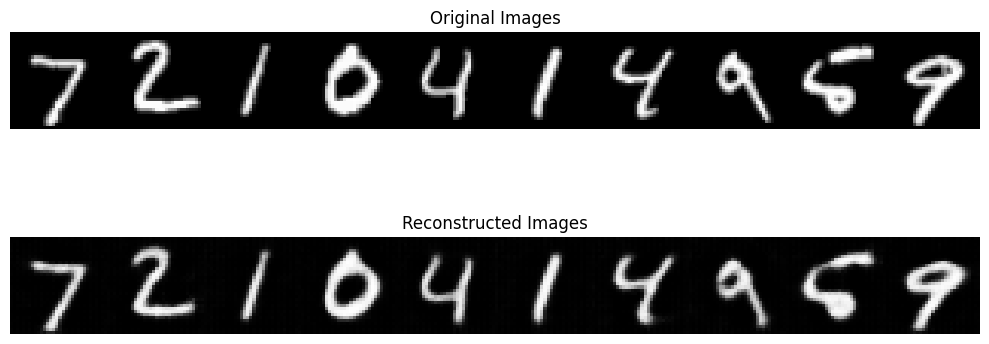

====> Epoch: 2 Average training loss: 0.0133
====> Test set loss: 0.0116
====> Epoch: 3 Average training loss: 0.0114
====> Test set loss: 0.0102
====> Epoch: 4 Average training loss: 0.0104
====> Test set loss: 0.0101
====> Epoch: 5 Average training loss: 0.0095
====> Test set loss: 0.0090
====> Epoch: 6 Average training loss: 0.0091
====> Test set loss: 0.0091
====> Epoch: 7 Average training loss: 0.0087
====> Test set loss: 0.0083
====> Epoch: 8 Average training loss: 0.0082
====> Test set loss: 0.0092
====> Epoch: 9 Average training loss: 0.0080
====> Test set loss: 0.0077
====> Epoch: 10 Average training loss: 0.0077
====> Test set loss: 0.0075


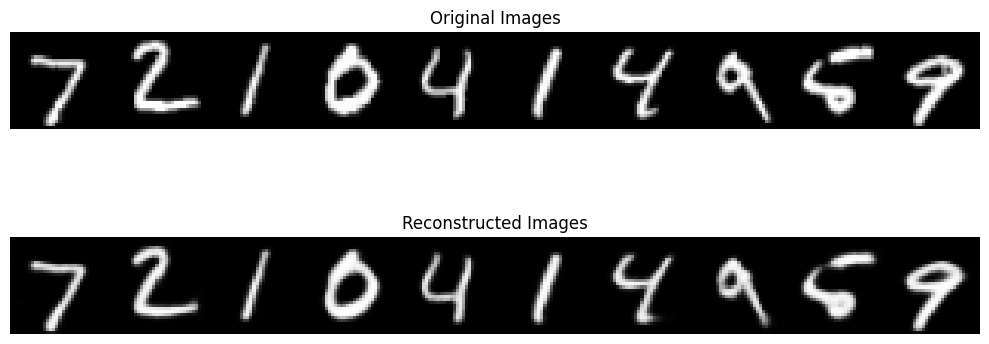

In [9]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    if epoch == 1 or epoch == 10:
      visualize_comparison(model, test_loader)

#### Plot the Training Loss

Text(0.5, 1.0, 'Training Loss')

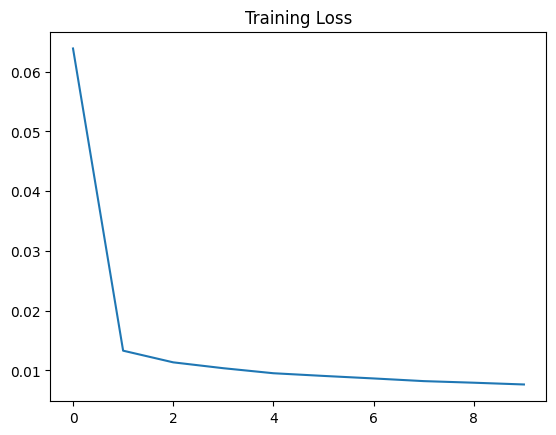

In [10]:
plt.plot(loss_log)
plt.title("Training Loss")

## Denoising Autoencoders

Denoising Autoencoders (DAEs) are a variant of autoencoders, which are a type of unsupervised neural network used primarily for the task of learning efficient representations of the input data, typically for the purpose of dimensionality reduction or feature learning. The unique aspect of Denoising Autoencoders is their ability to reconstruct clean ("denoised") input data from data that has been intentionally corrupted with some form of noise. This process encourages the autoencoder to learn more robust and essential features of the data, rather than simply memorizing or overfitting to the noise-free training data. Here's an overview of the approach used in Denoising Autoencoders:

1. Data Corruption
In the first step, the original input data is intentionally corrupted. This corruption usually involves adding some form of noise, such as Gaussian noise, masking noise (where parts of the input are randomly set to zero), or salt-and-pepper noise (randomly flipping some of the input values). The corrupted data serves as the actual input to the Denoising Autoencoder.

2. Encoding
The corrupted data is then passed through the encoder part of the autoencoder. This process is aimed at capturing the most important features of the data necessary for reconstructing the original, uncorrupted version.

3. Decoding
Following encoding, the latent representation is passed through the decoder part of the autoencoder, uncorrupted input data from the latent representation. The goal of this step is to generate a clean output that is as close as possible to the original input data before corruption.

4. Loss Calculation
The reconstruction loss is calculated by comparing the reconstructed data to the original, uncorrupted data. This loss measures how well the Denoising Autoencoder has learned to remove the noise and reconstruct the clean data.

5. Training
Through training, the Denoising Autoencoder learns to ignore the added noise and to capture and reconstruct the important features of the original data.

The Denoising Autoencoder not only learns a robust representation of the data but also improves its ability to generalize from the training data to unseen data, making it useful for tasks like denoising, anomaly detection, and even generative models.

The ability to recover clean data from noisy inputs makes DAEs particularly useful in applications where data quality is an issue, such as image processing, signal processing, and more broadly, in improving the robustness of machine learning models.

In [11]:
# Get a test image
dataiter = iter(test_loader)
test_images = next(dataiter)[0]
# View the shape
test_images.shape

torch.Size([64, 1, 32, 32])

In [12]:
# The size of the Latent Vector
latent_size = 128

# Create our network
noisy_net = Autoencoder(input_channels=1, hidden_dim=32, z_dim=32).to(device)

# Setup optimizer
optimizer = optim.Adam(noisy_net.parameters(), lr=learning_rate)

# MSE loss for reconstruction!
loss_func = nn.MSELoss()

loss_log = []
train_loss = 0

noise_scale = 0.3

In [13]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):

        image = data[0].to(device)

        # Create the noisy data!
        random_sample = (torch.bernoulli((1 - noise_scale) * torch.ones_like(image)) * 2) - 1
        noisy_img = random_sample * image

        # Forward pass the image in the data tuple
        recon_data = noisy_net(noisy_img)

        # Calculate the MSE loss
        loss = criterion(recon_data, image)

        # Log the loss
        loss_log.append(loss.item())
        train_loss = loss.item()

        # Take a training step
        noisy_net.zero_grad()
        loss.backward()
        optimizer.step()

Here, noise is added to the images. The process uses PyTorch's bernoulli function to generate a random sample based on a Bernoulli distribution. The $(torch.ones\_like(test\_images)$) creates a tensor of ones with the same shape as test_images. This tensor is multiplied by $((1 - noise\_scale)$), adjusting the probability of generating a 1 in the Bernoulli distribution based on the $(noise\_scale$) parameter.

The result is then scaled by 2 and offset by -1 to transform the range from $([0,1]$) to $([-1,1]$), which is a common practice when dealing with image data in machine learning to center the pixel values around zero.

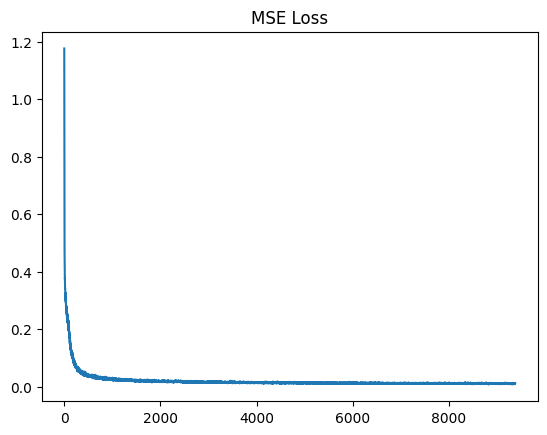

In [14]:
# Plot the loss over time
_ = plt.plot(loss_log)
_ = plt.title("MSE Loss")

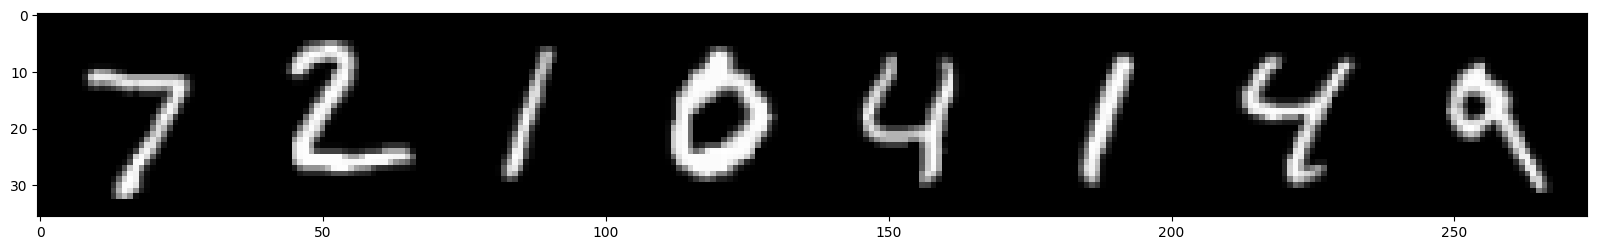

In [15]:
# Ground Truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

<Figure size 2000x1000 with 0 Axes>

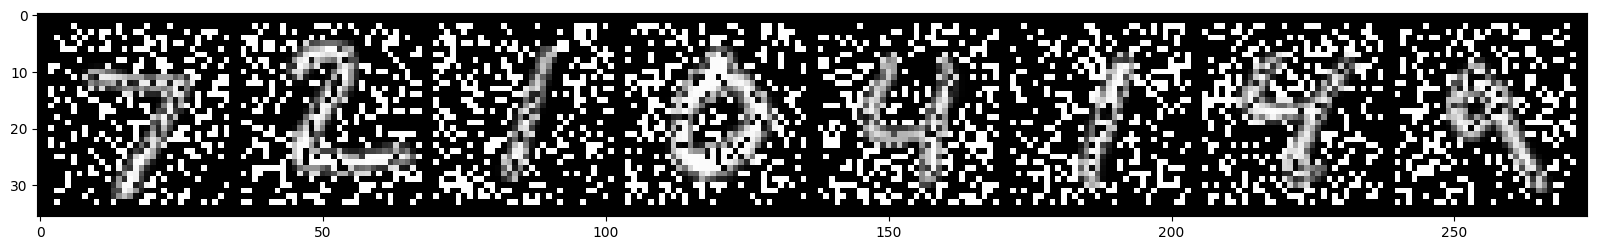

In [16]:
# Visualize the noisy data!!!
noise_scale = 0.3
plt.figure(figsize = (20, 10))
random_sample = (torch.bernoulli((1 - noise_scale) * torch.ones_like(test_images)) * 2) - 1
noisy_test_img = random_sample * test_images

# Noisy Input
plt.figure(figsize = (20,10))
out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

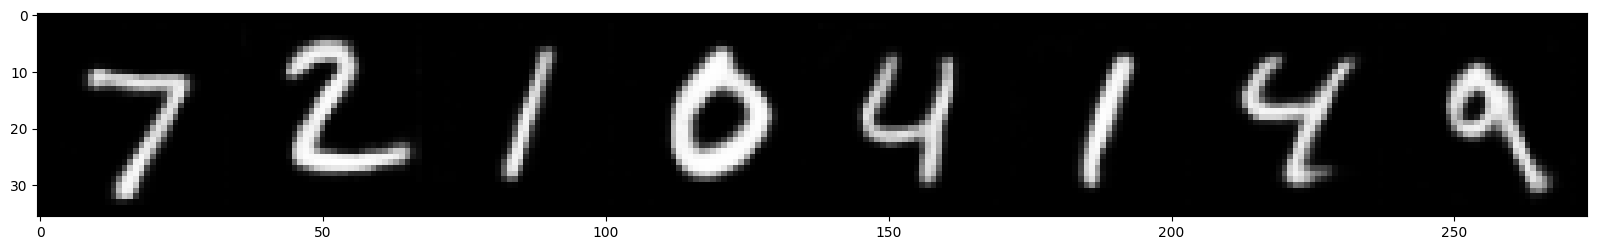

In [17]:
# Reconstruction
plt.figure(figsize = (20,10))
recon_data = noisy_net(noisy_test_img.to(device))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Variational Autoencoders

Autoencoders, particularly the basic ones, are powerful tools for learning compressed representations of data. However, when faced with data significantly different from what they were trained on, their performance in generating accurate reconstructions can diminish. This limitation is partly because basic autoencoders learn a deterministic mapping from input to a compressed representation and back, without considering the distribution of the input data in the latent space. This can lead to poor generalization to new, unseen data.


### Demonstrating Limitations with Unseen Data

Consider a scenario where we have trained a basic autoencoder on the MNIST dataset, which consists of handwritten digits. If we try to feed the autoencoder an image that is not a handwritten digit (e.g., a picture of a cat), the model may struggle to generate a meaningful representation. This is because the model has learned specific features and patterns associated with digits and does not know how to handle significantly different inputs.

### Why Basic Autoencoders Struggle with New Data

The primary reason lies in the encoder part of the autoencoder, which compresses the input into a fixed representation in the latent space. For inputs similar to the training data, this representation can be effectively decoded into accurate reconstructions. However, for vastly different inputs, the encoder might project them into parts of the latent space that do not correspond to any meaningful output for the decoder, resulting in poor reconstructions.

###Variational Autoencoders (VAEs) to the Rescue

Variational Autoencoders (VAEs) introduce a probabilistic twist to the autoencoder architecture, allowing them to model the distribution of the input data in the latent space. Unlike traditional autoencoders, VAEs do not learn a direct mapping from input to a fixed point in the latent space. Instead, they learn the parameters (mean and variance) of a probability distribution for each input. This approach enables VAEs to generate new data points by sampling from the latent space, making them particularly suited for tasks like data generation and anomaly detection.

### Components of a VAE

Encoder (Recognition Model): The encoder in a VAE takes input data and transforms it into a distribution over the latent space. Unlike traditional autoencoders that directly produce a single latent representation, the encoder in a VAE outputs parameters to a probability distribution—typically the mean and variance of a Gaussian distribution. This probabilistic approach allows for the modeling of uncertainty and variability in the data representations.

Latent Space (Latent Variables): The latent space in VAEs represents compressed knowledge of the input data. Because the encoder outputs parameters of a distribution, each point in the latent space is actually a distribution over possible values rather than a single fixed value. This stochastic nature of the latent space allows VAEs to generate new data points.

Decoder (Generative Model): The decoder takes a sampled point from the latent space distribution and attempts to reconstruct the input data from this sampled latent representation. The goal is to produce output that is as close as possible to the original input, given the probabilistic nature of the latent space.

### How VAEs Work

**Probabilistic Encoding:** The encoder produces a probability distribution for each latent attribute. To generate a latent representation for a given input, a point is sampled from these distributions. This introduces randomness into the latent representation, which is crucial for the generative aspect of VAEs.

**Reconstruction Loss:** Like traditional autoencoders, VAEs use a reconstruction loss to measure how well the decoded samples match the original inputs. This encourages the decoder to learn accurate reconstructions.

**Regularization:** VAEs introduce a regularization term in the loss function that measures how much the learned distribution diverges from a prior distribution (usually a standard Gaussian distribution). This term, often derived from the Kullback-Leibler (KL) divergence, ensures that the latent space has good properties for generating data, such as continuity and completeness. A continuous latent space means that small changes in the latent variables result in small changes in the output. Completeness means that for points sampled from the latent space, the decoder can produce outputs that resemble the input data.

### Training VAEs

VAEs are trained by optimizing both the reconstruction loss and the KL divergence simultaneously. This dual objective encourages the model to find a balance between accurately reconstructing the original data and maintaining a regularized latent space that is suitable for generating new data. The training process involves backpropagation and an optimization algorithm (e.g., Adam) to update the weights of the encoder and decoder networks.

### Prior Distribution Selection


The prior distribution in the context of Variational Autoencoders (VAEs) refers to the assumed or chosen probability distribution that represents how we expect the latent variables (the hidden representations) to be distributed before we observe any actual data. In simpler terms, it's our initial guess or assumption about the distribution of the latent space.

In VAEs, the prior distribution is typically chosen to be a standard Gaussian (normal) distribution, represented as $N(0, I)$, where $0$ is a zero mean vector and $I$ is the identity matrix as the covariance matrix. This choice is made for several reasons:

**Simplicity and Mathematical Tractability:** The Gaussian distribution is mathematically well-understood and has nice properties, such as symmetry and the fact that linear combinations of Gaussian variables are also Gaussian. This makes it easier to work with analytically and computationally.

**Regularization:** By assuming a standard Gaussian prior, we effectively regularize the latent space. This encourages the model to learn a well-structured and continuous latent space where similar points result in similar outputs when decoded, which is beneficial for generating new data that resembles the training data.

**Sampling:** A standard Gaussian distribution makes it straightforward to sample new latent variables. Since the distribution is defined by a simple zero mean and identity covariance, sampling can be done efficiently, which is essential for generating new data points.

The choice of a prior distribution is crucial because it influences how the latent space is structured and how data is generated from the latent variables. The KL divergence part of the VAE loss function measures how much the distribution of latent variables (as learned by the encoder from the data) diverges from this prior distribution. The regularization effect of the KL term encourages the learned distribution to be similar to the prior, which in the case of a standard Gaussian means encouraging the latent variables to be distributed in a way that is regular, smooth, and well-suited for sampling and generating new data.

### KL Divergence

#### KL Divergence Definition

The KL divergence is a measure of how one probability distribution diverges from a second, reference probability distribution. It's often used in the context of machine learning and information theory to measure the difference between two distributions.

For two discrete probability distributions $(P$) and $(Q$) defined on the same probability space, $(X$), the KL divergence from $(Q$) to $(P$) is defined as:

$$
D_{KL}(P \parallel Q) = \sum_{x \in X} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$

This formula is not symmetric, meaning $(D_{KL}(P \parallel Q) \neq D_{KL}(Q \parallel P)$).

#### Simple Example

Let's consider two simple probability distributions \(P\) and \(Q\) over a space of three outcomes \(X = \{x_1, x_2, x_3\}\):

- Let $(P = \{0.2, 0.5, 0.3\}$) be the true distribution of data.
- Let $(Q = \{0.1, 0.4, 0.5\}$) be the model's estimated distribution.

We can calculate the KL divergence from $(Q$) to $(P$) to see how much $(Q$) diverges from $(P$).

#### Calculation

$$
D_{KL}(P \parallel Q) = \sum_{i=1}^3 P(x_i) \log \left( \frac{P(x_i)}{Q(x_i)} \right)
$$

Let's compute this step by step:


In [18]:
import numpy as np

# Define the distributions
P = np.array([0.2, 0.5, 0.3])
Q = np.array([0.1, 0.4, 0.5])

# Calculate the KL divergence
D_KL = np.sum(P * np.log(P / Q))
D_KL

0.09695352463929671

This calculation will give us the KL divergence in bits (if log base 2 is used) or nats (if natural log is used), representing the amount of information lost when $(Q$) is used to approximate $(P$).

The KL divergence from $(Q$) to $(P$) in this example is approximately
0.097 nats. This value quantifies the information loss when $(Q$) is used to approximate $(P$), indicating that $(Q$) is not a perfect representation of
$(P$) but the divergence is relatively small.

In the context of VAEs, minimizing the KL divergence between the learned distribution and the prior distribution helps to ensure that the latent space representation is efficient and meaningful for generating data similar to the input data

### Applications

VAEs have a wide range of applications, including:

**Data Generation:** Generating new data samples that resemble the original dataset, useful in domains such as images, music, and text.

**Anomaly Detection:** Anomalies can be detected by evaluating how well the VAE can reconstruct input data, with poor reconstructions indicating outliers.

**Interpolation:** Generating smooth transitions between data points by interpolating in the latent space.

**Feature Extraction and Representation Learning:** Learning useful representations that can be used for downstream tasks like classification or clustering.

### VAE Results


In Variational Autoencoders (VAEs), the separation of clusters in the latent space is not explicitly enforced by the model architecture or the loss function. Instead, the clustering effect—where similar data points are grouped together in the latent space—emerges naturally from the training process, particularly through the interplay between the reconstruction loss and the regularization term involving the Kullback-Leibler (KL) divergence. Here's how these components contribute to the clustering of data in the latent space:

1. Reconstruction Loss
The reconstruction loss (e.g., mean squared error or binary cross-entropy) encourages the VAE to learn an encoding-decoding scheme that can accurately reconstruct the input data from the latent representations. For the reconstruction to be accurate, the encoder needs to learn to map similar input data points to nearby points in the latent space, because the decoder learns to map regions of the latent space to specific kinds of outputs. This pressure inherently encourages a form of clustering, where similar inputs are pushed towards similar regions in the latent space.

2. KL Divergence Regularization
The KL divergence term in the VAE loss function measures the divergence between the learned latent variable distributions (for each input data point, typically modeled as a Gaussian defined by encoder-produced means and variances) and a prior distribution (typically a standard Gaussian distribution). This term ensures that the latent space does not overfit to the training data and is smoothly filled, making it possible to sample new data points from the latent space that resemble the training data.

The effect of the KL divergence on clustering is more indirect. By encouraging the latent representations to conform to a standard Gaussian distribution, it prevents the model from placing representations too far apart unless necessary for reconstruction. This means that while the model is encouraged to use the entire latent space smoothly (avoiding overly dense clustering in one area), it still ends up placing similar data points closer together because that's efficient for both accurate reconstruction and adherence to the Gaussian prior.

#### Emergent Clustering
The combination of these pressures—accurate reconstruction and regularization towards a Gaussian prior—leads to an emergent clustering effect where similar data points are encoded to similar regions of the latent space. However, it's important to note that VAEs do not explicitly ensure that these clusters are well-separated or easily interpretable. The separation and distinctness of clusters in the latent space depend on factors such as the complexity of the data, the capacity of the encoder and decoder networks, and the balance between the reconstruction loss and the KL divergence.

For tasks where more explicit clustering or separation in the latent space is desired, modifications to the standard VAE or different models altogether, like Gaussian Mixture VAEs (GMVAEs) or clustering-specific loss functions, might be used. These approaches can introduce additional terms or constraints to the loss function to more directly encourage the formation of distinct, well-separated clusters in the latent space.

### VAE Implementation

To convert the provided Convolutional Autoencoder implementation into a Variational Autoencoder (VAE), we need to modify the encoder to output two vectors (means and log variances) instead of a single latent representation. These vectors will be used to parameterize a Gaussian distribution from which we sample to generate the latent variables. This sampling step introduces stochasticity into the model, making it variational. Also, the loss function of the VAE typically includes both a reconstruction loss and a Kullback-Leibler divergence term to regularize the latent space.

In [7]:
class VAE_Encoder(nn.Module):
    """
    Encoder module for a Variational Autoencoder.
    Outputs two vectors: means and log variances for the latent space distribution parameters.
    """
    def __init__(self, input_channels, hidden_dim=32, z_dim=32):
        super(VAE_Encoder, self).__init__()
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim * 4 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4 * 4 * 4, z_dim)

    def forward(self, x):
        x = self.encoder_layers(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class VAE_Decoder(nn.Module):
    """
    Decoder module for a Variational Autoencoder.
    Takes a sample from the latent space and reconstructs the input data.
    """
    def __init__(self, output_channels, hidden_dim=32, z_dim=32):
        super(VAE_Decoder, self).__init__()
        # Adjust the starting size based on your architecture and input image size
        self.fc = nn.Linear(z_dim, hidden_dim * 4 * 4 * 4)  # Reverse of encoder's flattening

        self.conv_transpose_layers = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            # Adjust kernel size, stride, padding to match the input image size
            nn.ConvTranspose2d(hidden_dim, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), # Assuming the input images are normalized between [-1, 1]
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 32 * 4, 4, 4)  # Reshape to the reverse of what encoder does
        return self.conv_transpose_layers(z)

class VAE(nn.Module):
    """
    Variational Autoencoder Module.
    Combines the Encoder and Decoder with a sampling step in between.
    """
    def __init__(self, input_channels, hidden_dim=32, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(input_channels, hidden_dim, z_dim)
        self.decoder = VAE_Decoder(input_channels, hidden_dim, z_dim)

    def reparameterize(self, mu, logvar):
        """
        The reparameterize function in the VAE class is a crucial
        component that performs the "reparameterization trick" to
        allow for gradient backpropagation through the stochastic
        sampling process.
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


#### The Reparameterization Trick

The "reparameterization trick" is a clever method used in Variational Autoencoders (VAEs) that allows us to train the model using gradient descent, even though part of the model involves random sampling, which normally doesn't let gradients flow through.

Here's a simple breakdown of the problem and how the trick works:

**The Problem:**
In a VAE, we want to generate new data points by sampling from a distribution learned by the model.
The encoder of a VAE produces two things for each input: the mean and the variance of a distribution that represents the input in a compressed, latent space.
We then sample a point from this distribution to feed into the decoder to reconstruct the input.
Normally, sampling is a random operation and doesn't allow the use of gradients, which are necessary for training the model with backpropagation. This means we wouldn't be able to adjust the model's parameters based on how well the decoder's output matches the original input.

**The Trick:**
Instead of directly sampling from the distribution defined by the mean and variance, we first sample from a standard normal distribution (which is a fixed, known distribution that doesn't depend on any parameters of our model).
Then, we transform this sample using the mean and variance produced by the encoder. Specifically, we scale the sample by the standard deviation (which is the square root of the variance) and then shift it by the mean. This transformation effectively "moves" and "shapes" the standard normal distribution to match the distribution we want.

**This process** allows the model to use the sampled values to reconstruct the input while still being able to calculate gradients for training because the randomness is now isolated from the model's parameters. The transformation using the mean and variance is a differentiable operation, so gradients can flow through it.

#### VAE Loss

To train a Variational Autoencoder (VAE), you need to compute two components of the loss function:

**Reconstruction Loss:** Measures how well the VAE is able to reconstruct the input data. Binary Cross-Entropy (BCE) is commonly used for binary inputs like MNIST digits.

**KL Divergence Loss:** Measures how much the learned latent variable distribution diverges from the prior distribution (typically a standard Gaussian distribution). This part ensures that the latent space has good properties, allowing us to generate new samples by interpolating points in this space.
VAE Loss Function with BCE

The total loss is the sum of the reconstruction loss and the KL divergence loss. Sometimes, the KL divergence is scaled to balance the two terms, but initially. After some empirical results, I decided to use 0.1 for the KL divergence. Here's the loss function:

In [8]:
def vae_loss_mse(recon_x, x, mu, logvar):
    """
    Calculate VAE loss consisting of reconstruction loss (using MSE) and KL divergence.

    Parameters:
    - recon_x: the reconstructed output.
    - x: the original input.
    - mu: the mean of the latent distribution.
    - logvar: the logarithm of the variance of the latent distribution.

    Returns:
    - Total loss as the sum of MSE and KL divergence.
    """
    # MSE reconstruction loss
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is the sum of MSE and KL divergence (scaled)
    return MSE + 0.3 * KL_divergence

#### Training and Testing Loop

In [9]:
# Number of epochs
num_epochs = 10

# Learning rate
learning_rate = 1e-3

# The size of the Latent Vector
latent_size = 128

# Hidden dimension
hidden_dimension = 32

# Create our network
vae_net = VAE(input_channels=1, hidden_dim=hidden_dimension, z_dim=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=learning_rate)

# MSE loss for reconstruction!
loss_func = nn.MSELoss()

loss_log = []
train_loss = 0

In [103]:
log_interval = 200

def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(device)

        vae_net.zero_grad()

        # Forward pass the image in the data tuple
        recon_batch, mu, logvar = vae_net(data)

        # Calculate the MSE loss
        loss = vae_loss_mse(recon_batch, data, mu, logvar)

        loss.backward()

        # Log the loss
        train_loss += loss.item()
        loss_log.append(loss)

        # Take a training step
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

In [104]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:

            data = data.to(device)

            recon_batch, mu, logvar = model(data)

            test_loss += vae_loss_mse(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

In [105]:
import torchvision.utils as vutils

def visualize_comparison(model, test_loader):
    model.eval()
    with torch.no_grad():
        # Grab a single batch from the test loader
        data, _ = next(iter(test_loader))
        data = data.to(device)

        # Generate output from the model
        recon_batch, mu, logvar = model(data)

        # Move the tensors back to CPU for visualization
        data = data.detach().cpu()
        output = recon_batch.detach().cpu()

        # Set up the figure
        plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

        # Display Original images
        out = vutils.make_grid(data[0:10], nrow=10, padding=0, normalize=True)
        plt.subplot(2, 1, 1)
        plt.imshow(out.numpy().transpose(1, 2, 0))
        plt.title('Original Images')
        plt.axis('off')

        # Display Reconstructed images
        out = vutils.make_grid(output[0:10], nrow=10, padding=0, normalize=True)
        plt.subplot(2, 1, 2)
        plt.imshow(out.numpy().transpose(1, 2, 0))
        plt.title('Reconstructed Images')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 1699.949463
Train Epoch: 1 [12800/60000 (21%)]	Loss: 67.684273
Train Epoch: 1 [25600/60000 (43%)]	Loss: 54.386894
Train Epoch: 1 [38400/60000 (64%)]	Loss: 49.772087
Train Epoch: 1 [51200/60000 (85%)]	Loss: 44.559258
====> Epoch: 1 Average loss: 78.8258
====> Test set loss: 43.8545


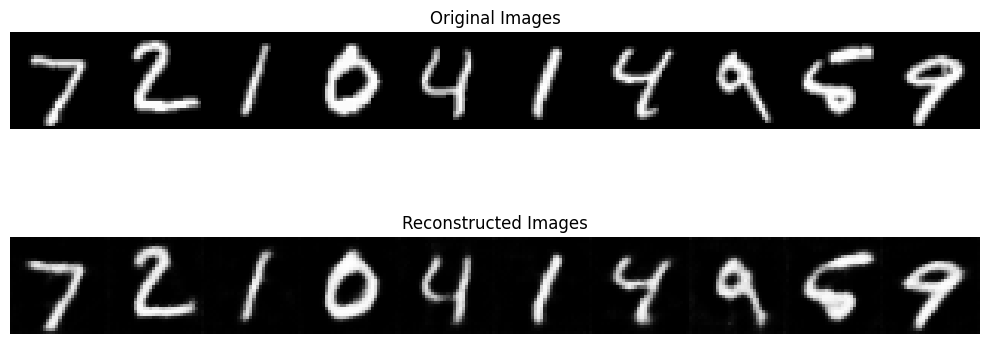

Train Epoch: 2 [0/60000 (0%)]	Loss: 43.118095
Train Epoch: 2 [12800/60000 (21%)]	Loss: 39.156654
Train Epoch: 2 [25600/60000 (43%)]	Loss: 41.533768
Train Epoch: 2 [38400/60000 (64%)]	Loss: 37.293575
Train Epoch: 2 [51200/60000 (85%)]	Loss: 37.156681
====> Epoch: 2 Average loss: 39.5634
====> Test set loss: 36.5394
Train Epoch: 3 [0/60000 (0%)]	Loss: 35.710846
Train Epoch: 3 [12800/60000 (21%)]	Loss: 39.440300
Train Epoch: 3 [25600/60000 (43%)]	Loss: 35.370888
Train Epoch: 3 [38400/60000 (64%)]	Loss: 37.329659
Train Epoch: 3 [51200/60000 (85%)]	Loss: 34.433376
====> Epoch: 3 Average loss: 36.0759
====> Test set loss: 34.6183
Train Epoch: 4 [0/60000 (0%)]	Loss: 34.593323


In [ ]:
for epoch in range(1, num_epochs + 1):
    train(vae_net, train_loader, optimizer, epoch)
    test(vae_net, test_loader)
    if epoch == 1 or epoch == 10:
      visualize_comparison(vae_net, test_loader)

#### Generating New Samples



To generate new MNIST-like samples, we can sample from the standard normal distribution and pass these samples through the decoder:

In [10]:
def generate_sample(model):
    model.eval()
    with torch.no_grad():
        # Sample from standard Gaussian and turn it to [-1, 1]
        sample = torch.rand(64, 1, 32, 32) * 2 - 1
        # Pass through the entire model to ensure correct processing
        recon_batch, mu, logvar = model(sample.to(device))
        return recon_batch.cpu()


In [11]:
sample = generate_sample(vae_net)
print(sample.shape)

torch.Size([64, 1, 32, 32])


In [12]:
# Visualize
def visualize_samples(sample, img_size=(32, 32)):
    sample = sample.view(64, *img_size)  # Reshape samples to 2D images
    grid_size = 8
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))

    for i, ax in enumerate(axs.flat):
        ax.imshow(sample[i].data.numpy(), cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

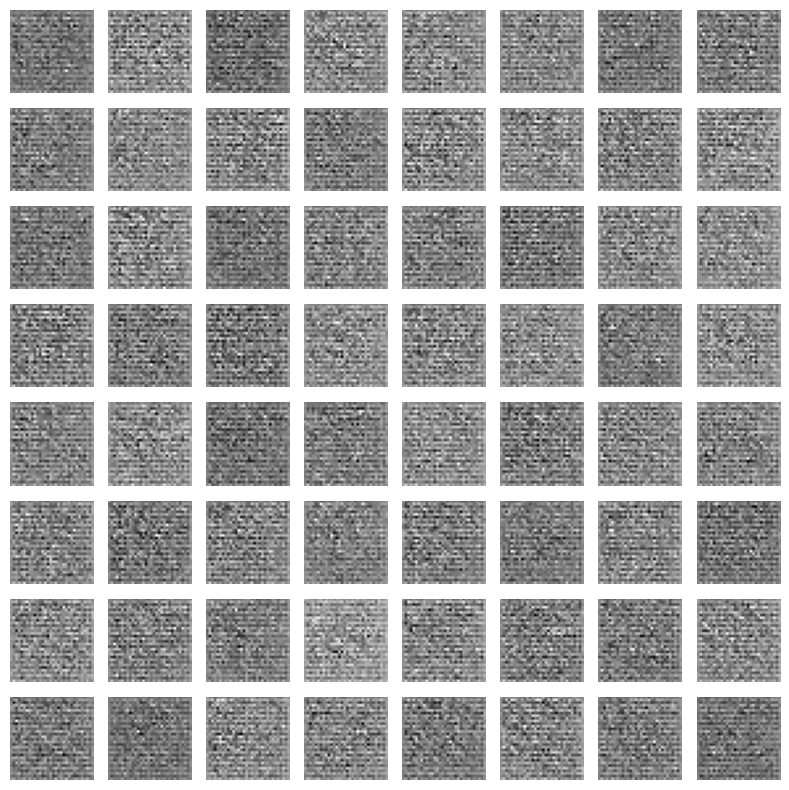

In [13]:
visualize_samples(sample)

#### Some Result Evaluation

The choice of scaling for the KL divergence loss in a Variational Autoencoder (VAE) can significantly affect the model's training dynamics and outcomes. Here are some reasons why using a scaling factor of 0.3 for the KL divergence resulted in better performance in your case:

**Balancing Reconstruction and Regularization:** The VAE loss function is a trade-off between the reconstruction loss (how well the model can recreate the input data) and the KL divergence loss (how well the latent variable distribution matches the prior distribution). A scaling factor of 0.3 on the KL divergence means you're giving more weight to the reconstruction loss relative to the KL divergence. This can lead to a model that is better at generating data that closely resembles the training data, as it focuses more on minimizing the reconstruction error.

**Avoiding Over-regularization:** Without proper scaling, the KL divergence loss can dominate the total loss, especially in the early stages of training. This can lead to over-regularization, where the model's latent space might end up being too constrained and not capturing enough variability of the data. By scaling down the KL divergence, it is allowed the model to explore a more diverse set of latent representations, which can be crucial for generating varied and realistic outputs.

**Stabilizing Training:** Scaling down the KL divergence can also help stabilize the training process. Large fluctuations in the KL divergence part of the loss can lead to unstable updates, especially with stochastic gradient descent methods. A smaller weight on the KL divergence can make training more stable and efficient by reducing the variance of the updates.

**Empirical Adjustment:** The optimal balance between reconstruction loss and KL divergence loss is highly dependent on the specific dataset and model architecture. There's often no theoretically optimal scaling factor; it needs to be empirically determined.

In summary, the improved results from using a scaling factor of 0.3 for the KL divergence in your VAE likely stem from a better balance between reconstruction accuracy and the regularization imposed by the KL term. This balance is crucial for training VAEs effectively, as it impacts both the quality of the reconstruction and the diversity of the generated samples.